# ICL 20/21 - ML Algorithm Fairness Coursework

The main task of the assignment is to study model selection process (when training ML models) that takes into account accuracy and fairness metrics. \\
The task is to compare standard ML models versus fairness-based ML models with three model selection criteria: 
1.   Most accurate
2.   Most fair
3.   Most accurate \& fair

**Task 1:**

The standard ML methods such as logistic regression or SVMs use a regularization parameter (lambda in the lecture slides, C in the ML libraries) to trade-off accuracy and generalization. The first task is to analyse whether or not better generalisation could correspond to fairer models.

*   Split the data into train/val/test
*   Perform cross validation by varying the trade-off hyperparameter and select the model 
    *   (1) with highest accuracy
    *   (2) with best fairness metric on the validation data

This is called models selection. Report the accuracy and fairness for both models on the test set.

**Task 2:**

Now choose an algorithmic fairness method (e.g. reweighing), and perform the same analysis, i.e. how varying the hyperparameter(s) impact accuracy and fairness metrics during model selection.
*   Using the same train/val/test split as in Task 1, perform cross validation by varying the trade-off hyperparameter and select
    *   (3) model with highest accuracy
    *   (4) model with best fairness metric on the validation data

Report the accuracy and fairness for both (3) \& (4) on the test set.

**Task 3:**

Based on your observations, suggest a model selection strategy (criterion) that accounts for both, accuracy and fairness. Compare your fairness-based model from the previous task and the standard classification model from the first task using the proposed criterion.
*    Using the same train/val/test split as before, perform cross validation by varying the trade-off hyperparameter. Select 
    *    (5) the highest scoring fairness-based model from Task 2
    *    (6) the highest scoring standard model from Task 1 on the validation data. 

Report the accuracy and fairness for both (5) and (6) on the test set.

**Final Results:**

The accuracy and fairness results for (1)-(6) models are obtained based on the initial train/val/test split. What if we had a different training/val/test data, would the results be exactly the same? Perform four more train/val/test splits (permute the data, split into tran/val/test, and do Task1, Task 2, Task3). Report the final results using mean and standard deviation of accuracy and of fairness over five splits.

Report accuracy \& fairness stats for the 6 models as a table in the report.\\
Include plots of cross-validation results (see specs for details).

Perform the empirical evaluations on (at least) two datasets: Adult Income and a dataset of your choice (from the aif360 library). Analyse one (or two) fairness metrics along with accuracy.

### Reading \& Sources

https://arxiv.org/pdf/1908.09635.pdf

https://files.eric.ed.gov/fulltext/ED599210.pdf


Notes for the report

- intuitively, one would expect that more focus on generalization would make a model more fair (because it can't overfit) 
- actually, no, it's probably the other way around? idk:)

### Setup

In [ ]:
!pip install 'aif360[LFR]'

In [ ]:
cd /usr/local/lib/python3.7/dist-packages/aif360/data/raw/adult

In [ ]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test

In [4]:
from aif360.datasets import AdultDataset

In [6]:
#Import the libraries and set the random seed.

import numpy as np
import math
import copy

from aif360.algorithms.preprocessing.optim_preproc_helpers.data_preproc_functions import load_preproc_data_adult

from aif360.metrics import ClassificationMetric
from aif360.algorithms.preprocessing.reweighing import Reweighing

import pdb

from sklearn.preprocessing import StandardScaler  #MinMaxScaler
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import *

SEED = 0
np.random.seed(SEED)

In [7]:
#We define where's the bias in the features of our dataset.
privileged_groups = [{'sex': 1}]
unprivileged_groups = [{'sex': 0}]
dataset_orig = load_preproc_data_adult(['sex'])

#We split between training and test set.
train, test = dataset_orig.split([0.9], shuffle=True)

# split the train set into 10 folds for cross-validation
folds = 10
folds_data = train.split(folds) # list of 10 sub-sets of type Dataset (not np)

scale_orig = StandardScaler()
scaler = scale_orig.fit(train.features) # fit a scaler on all the train data

# get the test data ready for later
X_test = scaler.transform(test.features)
y_test = test.labels.ravel()

### Task 1

#### Logistic regression: CV

In [50]:
# Actual cross-validation

C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,1e-5,1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e5, 1e10,] 
metric_arrs = dict()

for c in C_params:
    metric_arrs[str(c)] = dict()
    metric_arrs[str(c)]['acc'] = []
    metric_arrs[str(c)]['bal_acc'] = []
    metric_arrs[str(c)]['disp_imp'] = []
    metric_arrs[str(c)]['stat_par_diff'] = []
    metric_arrs[str(c)]['eq_opp_diff'] = []
    metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_labels = np.concatenate(concat_labels)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(scaler.transform(val.features))
        val_pred = val.copy()
        val_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [51]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-15 {'acc': 0.7933660034305672, 'bal_acc': 0.679322209538683, 'disp_imp': 0.33548993235523367, 'stat_par_diff': -0.15920514856525686, 'eq_opp_diff': -0.2326096937658822, 'avg_odds_diff': -0.15131223542016486}
1.00e-10 {'acc': 0.7933660034305672, 'bal_acc': 0.679322209538683, 'disp_imp': 0.33548993235523367, 'stat_par_diff': -0.15920514856525686, 'eq_opp_diff': -0.2326096937658822, 'avg_odds_diff': -0.15131223542016486}
1.00e-09 {'acc': 0.7933660034305672, 'bal_acc': 0.679322209538683, 'disp_imp': 0.33548993235523367, 'stat_par_diff': -0.15920514856525686, 'eq_opp_diff': -0.2326096937658822, 'avg_odds_diff': -0.15131223542016486}
1.00e-08 {'acc': 0.7933660034305672, 'bal_acc': 0.679322209538683, 'disp_imp': 0.33548993235523367, 'stat_par_diff': -0.15920514856525686, 'eq_opp_diff': -0.2326096937658822, 'avg_odds_diff': -0.15131223542016486}
1.00e-07 {'acc': 0.7933660034305672, 'bal_acc': 0.6792562570336308, 'disp_imp': 0.3356926485635592, 'stat_par_diff': -0.15906927900003942, 'eq_o

In [52]:
acc = []
bal_acc = []
disp_imp = []
stat_par = []
eq_op = []
avg_odds = []

for key in cv_results.keys():
    acc.append(cv_results[key]['acc'])
    bal_acc.append(cv_results[key]['bal_acc'])
    disp_imp.append(cv_results[key]['disp_imp'])
    stat_par.append(cv_results[key]['stat_par_diff'])
    eq_op.append(cv_results[key]['eq_opp_diff'])
    avg_odds.append(cv_results[key]['avg_odds_diff'])

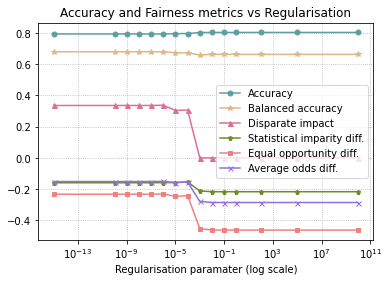

In [53]:
import matplotlib.pyplot as plt

plt.plot(C_params, acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log scale)")
plt.title("Accuracy and Fairness metrics vs Regularisation")
plt.show()

For a linear model, the regularization doesn't seem to make a difference, see https://www.kaggle.com/joparga3/2-tuning-parameters-for-logistic-regression .

#### Final model evaluation

In [12]:
# Evaluating final model

metric_arrs = dict()
final_cs = [1e-2, 1e-6]

for c in final_cs:
    for seed in range(5):
        SEED = seed
        np.random.seed(SEED)

        metric_arrs[str(c)] = dict()
        metric_arrs[str(c)]['acc'] = []
        metric_arrs[str(c)]['bal_acc'] = []
        metric_arrs[str(c)]['disp_imp'] = []
        metric_arrs[str(c)]['stat_par_diff'] = []
        metric_arrs[str(c)]['eq_opp_diff'] = []
        metric_arrs[str(c)]['avg_odds_diff'] = []
        
        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [13]:
cv_results = dict()

for key in metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in metric_arrs[key].keys():
        cv_results[key][key_2] = sum(metric_arrs[key][key_2])/len(metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

1.00e-02 {'acc': 0.8143295803480041, 'bal_acc': 0.662722347778576, 'disp_imp': 0.0, 'stat_par_diff': -0.19957147229874503, 'eq_opp_diff': -0.44618599791013586, 'avg_odds_diff': -0.27179429765636665}
1.00e-06 {'acc': 0.810849539406346, 'bal_acc': 0.688175687938439, 'disp_imp': 0.28415775837123297, 'stat_par_diff': -0.16192452297632656, 'eq_opp_diff': -0.2321399109057911, 'avg_odds_diff': -0.15160115912871042}


In [14]:
# set seed back to what it was originally
SEED = 0

#### Extra: Same but with an SVM

In [ ]:
from sklearn.svm import SVC

C_params = [1e-10, 1e-7, 1e-3, 1, 1e7, 1e20]
# kernels = ['linear', 'poly', 'rbf']
metric_arrs_svm = dict()
kernel = 'rbf'

for c in C_params:
#    for kernel in kernels:
        print(c)
        learner = SVC(random_state=1, C=c, kernel=kernel) 
        learner.fit(X_train,y_train)
        predictions = learner.predict(X_val)
        key = str(c)+"_"+kernel
        metric_arrs_svm[key] = dict()

        val_pred = val.copy() # why do we need this?
        val_pred.labels = predictions

        metric_arrs_svm[key]['acc'] = sum(predictions==y_val)/len(y_val)

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        
        
        #Balanced accuracy
        metric_arrs_svm[key]['bal_acc']=((metric.true_positive_rate() + metric.true_negative_rate()) / 2)

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        metric_arrs_svm[key]['disp_imp']=(metric.disparate_impact())

        #Statistical Parity Difference (closer to 0 better)
        metric_arrs_svm[key]['stat_par_diff']=(metric.statistical_parity_difference())

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        metric_arrs_svm[key]['eq_opp_diff']=(metric.equal_opportunity_difference())

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        metric_arrs_svm[key]['avg_odds_diff']=(metric.average_odds_difference())

for key in metric_arrs_svm.keys():
    print('{:.2e}'.format(float(key)), metric_arrs_svm[key])

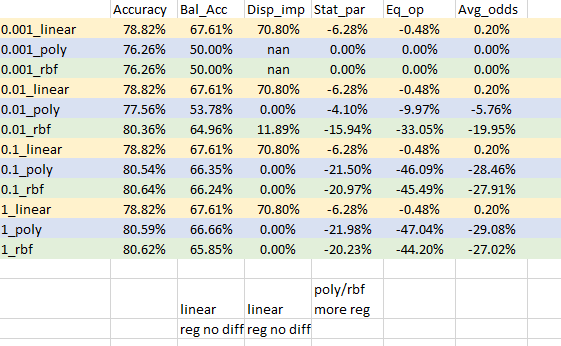

### Task 2

#### Logistic regression: CV

In [46]:
# Actual cross-validation

# C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6,1e-5,1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e5, 1e10,] 
C_params = [1e-15, 1e-10, 1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3,1e-2, 1e-1, 1, 1e2, 1e3, 1e4, 1e5, 1e7,1e8,1e9, 1e10, 1e15] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []

    for i in range(folds):
        # set aside a validation fold
        val = folds_data[i]
        labels_val = folds_data[i].labels.ravel()

        # concatenate the remaining folds to get the train set
        to_concat = folds_data[:i] + folds_data[i+1 :]
        concat_labels = [data.labels.ravel() for data in to_concat]
        w_to_concat = [(reweights.transform(data)).instance_weights for data in to_concat]
        to_concat = [scaler.transform(data.features) for data in to_concat]

        train_np = np.concatenate(to_concat, axis=0)
        train_weights = np.concatenate(w_to_concat, axis=0)
        train_labels = np.concatenate(concat_labels)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels, sample_weight=train_weights)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(scaler.transform(val.features))
        val_pred = val.copy()
        val_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==labels_val)/len(labels_val))

        metric = ClassificationMetric(val, val_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [47]:
f_cv_results = dict()

for key in f_metric_arrs.keys():
    f_cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        f_cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in f_cv_results.keys():
    print('{:.2e}'.format(float(key)), f_cv_results[key])

1.00e-15 {'acc': 0.7851306234543556, 'bal_acc': 0.6771435551870834, 'disp_imp': 0.699143891452842, 'stat_par_diff': -0.06690212601288331, 'eq_opp_diff': 0.002539804017925551, 'avg_odds_diff': 0.002137255117300444}
1.00e-10 {'acc': 0.7851306234543556, 'bal_acc': 0.6771435551870834, 'disp_imp': 0.699143891452842, 'stat_par_diff': -0.06690212601288331, 'eq_opp_diff': 0.002539804017925551, 'avg_odds_diff': 0.002137255117300444}
1.00e-09 {'acc': 0.7851306234543556, 'bal_acc': 0.6771435551870834, 'disp_imp': 0.699143891452842, 'stat_par_diff': -0.06690212601288331, 'eq_opp_diff': 0.002539804017925551, 'avg_odds_diff': 0.002137255117300444}
1.00e-08 {'acc': 0.7851306234543556, 'bal_acc': 0.6771435551870834, 'disp_imp': 0.699143891452842, 'stat_par_diff': -0.06690212601288331, 'eq_opp_diff': 0.002539804017925551, 'avg_odds_diff': 0.002137255117300444}
1.00e-07 {'acc': 0.7851306234543556, 'bal_acc': 0.6771435551870834, 'disp_imp': 0.699143891452842, 'stat_par_diff': -0.06690212601288331, 'eq_op

In [48]:
r_acc = []
r_bal_acc = []
r_disp_imp = []
r_stat_par = []
r_eq_op = []
r_avg_odds = []

for key in f_cv_results.keys():
    r_acc.append(f_cv_results[key]['acc'])
    r_bal_acc.append(f_cv_results[key]['bal_acc'])
    r_disp_imp.append(f_cv_results[key]['disp_imp'])
    r_stat_par.append(f_cv_results[key]['stat_par_diff'])
    r_eq_op.append(f_cv_results[key]['eq_opp_diff'])
    r_avg_odds.append(f_cv_results[key]['avg_odds_diff'])

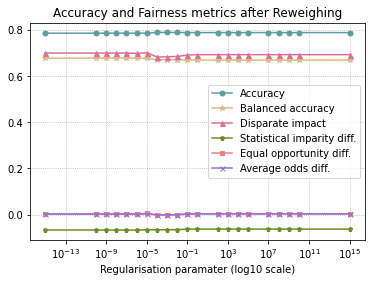

In [49]:
import matplotlib.pyplot as plt

plt.plot(C_params, r_acc, color='cadetblue', marker = "o", markersize=5, label = "Accuracy")
plt.plot(C_params, r_bal_acc, color = 'burlywood', marker = "*",markersize=6, label = "Balanced accuracy")
plt.plot(C_params, r_disp_imp, color= 'palevioletred', marker ="^", markersize=5, label = "Disparate impact")
plt.plot(C_params, r_stat_par, color = 'olivedrab', marker = "p", markersize=5, label = "Statistical imparity diff.")
plt.plot(C_params, r_eq_op, color = 'lightcoral', marker = "s", markersize=4, label = "Equal opportunity diff.")
plt.plot(C_params, r_avg_odds,color='mediumpurple', marker = "x", markersize=5, label = "Average odds diff.")
plt.grid(True, which="major", linestyle="dotted")
plt.legend()
plt.xscale("log")
plt.xlabel("Regularisation paramater (log10 scale)")
plt.title("Accuracy and Fairness metrics after Reweighing")
plt.show()

#### Final model evaluation

In [43]:
# Final model evaluation

C_params = [1e-3, 1e-5] 
f_metric_arrs = dict()

RW = Reweighing(unprivileged_groups=unprivileged_groups,
                privileged_groups=privileged_groups)

reweights = RW.fit_transform(train)

for c in C_params:
    f_metric_arrs[str(c)] = dict()
    f_metric_arrs[str(c)]['acc'] = []
    f_metric_arrs[str(c)]['bal_acc'] = []
    f_metric_arrs[str(c)]['disp_imp'] = []
    f_metric_arrs[str(c)]['stat_par_diff'] = []
    f_metric_arrs[str(c)]['eq_opp_diff'] = []
    f_metric_arrs[str(c)]['avg_odds_diff'] = []
    for SEED in range(5):

        train_labels = train.labels.ravel()
        train_np = scaler.transform(train.features)

        # fit the model
        learner = LogisticRegression(solver='liblinear', random_state=SEED, C=c) 
        learner.fit(train_np, train_labels, sample_weight = reweights.instance_weights)

        # make predictions on the validation set and save tem as Dataset labels
        predictions = learner.predict(X_test)
        test_pred = test.copy()
        test_pred.labels = predictions

        f_metric_arrs[str(c)]['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

        metric = ClassificationMetric(test, test_pred, 
                                    unprivileged_groups = unprivileged_groups, 
                                    privileged_groups = privileged_groups)
        #Balanced accuracy
        f_metric_arrs[str(c)]['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

        #Disparate Impact (closer to 1 better, close to 0 strong bias)
        f_metric_arrs[str(c)]['disp_imp'].append((metric.disparate_impact()))

        #Statistical Parity Difference (closer to 0 better)
        f_metric_arrs[str(c)]['stat_par_diff'].append((metric.statistical_parity_difference()))

        #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
        f_metric_arrs[str(c)]['eq_opp_diff'].append((metric.equal_opportunity_difference()))

        #Average of difference in FPR and TPR for unprivileged and privileged groups. 
        f_metric_arrs[str(c)]['avg_odds_diff'].append((metric.average_odds_difference()))

In [45]:
cv_results = dict()

for key in f_metric_arrs.keys():
    cv_results[key] = dict()
    for key_2 in f_metric_arrs[key].keys():
        cv_results[key][key_2] = sum(f_metric_arrs[key][key_2])/len(f_metric_arrs[key][key_2])

for key in cv_results.keys():
    print('{:.2e}'.format(float(key)), cv_results[key])

# for key in f_metric_arrs.keys():
#     for key_2 in f_metric_arrs[key].keys():
#         print(key)
#         print(f_metric_arrs[key][key_2])

1.00e-03 {'acc': 0.8055271238485158, 'bal_acc': 0.6774087397411013, 'disp_imp': 0.6785162458061098, 'stat_par_diff': -0.060616465437231815, 'eq_opp_diff': 0.05872930759500633, 'avg_odds_diff': 0.031095074354663153}
1.00e-05 {'acc': 0.8034800409416581, 'bal_acc': 0.6846825042793172, 'disp_imp': 0.6781213233651541, 'stat_par_diff': -0.06542009222085635, 'eq_opp_diff': 0.06101165924214924, 'avg_odds_diff': 0.030917764207634035}


In [41]:
SEED = 0

### Task 3

In [64]:
metric_arrs = dict()
metric_arrs['acc'] = []
metric_arrs['bal_acc'] = []
metric_arrs['disp_imp'] = []
metric_arrs['stat_par_diff'] = []
metric_arrs['eq_opp_diff'] = []
metric_arrs['avg_odds_diff'] = []

f_metric_arrs = dict()
f_metric_arrs['acc'] = []
f_metric_arrs['bal_acc'] = []
f_metric_arrs['disp_imp'] = []
f_metric_arrs['stat_par_diff'] = []
f_metric_arrs['eq_opp_diff'] = []
f_metric_arrs['avg_odds_diff'] = []

for SEED in range(5):

    np.random.seed(SEED)
    #We split between training and test set.
    train, test = dataset_orig.split([0.9], shuffle=True)

    # split the train set into 10 folds for cross-validation
    folds = 10
    folds_data = train.split(folds) # list of 10 sub-sets of type Dataset (not np)

    scale_orig = StandardScaler()
    scaler = scale_orig.fit(train.features) # fit a scaler on all the train data

    # get the test data ready for later
    X_test = scaler.transform(test.features)
    y_test = test.labels.ravel()

    train_labels = train.labels.ravel()
    train_np = scaler.transform(train.features)

    ##### REGULARISATION FINAL EVAL HERE #####


    # fit the model
    learner = LogisticRegression(solver='liblinear', random_state=SEED, C=1e-06) 
    learner.fit(train_np, train_labels)

    # make predictions on the validation set and save tem as Dataset labels
    predictions = learner.predict(X_test)
    test_pred = test.copy()
    test_pred.labels = predictions

    metric_arrs['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

    metric = ClassificationMetric(test, test_pred, 
                                unprivileged_groups = unprivileged_groups, 
                                privileged_groups = privileged_groups)
    #Balanced accuracy
    metric_arrs['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

    #Disparate Impact (closer to 1 better, close to 0 strong bias)
    metric_arrs['disp_imp'].append((metric.disparate_impact()))

    #Statistical Parity Difference (closer to 0 better)
    metric_arrs['stat_par_diff'].append((metric.statistical_parity_difference()))

    #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
    metric_arrs['eq_opp_diff'].append((metric.equal_opportunity_difference()))

    #Average of difference in FPR and TPR for unprivileged and privileged groups. 
    metric_arrs['avg_odds_diff'].append((metric.average_odds_difference()))

    ##### REWEIGHING FINAL EVAL HERE #####

    RW = Reweighing(unprivileged_groups=unprivileged_groups,
                    privileged_groups=privileged_groups)

    reweights = RW.fit_transform(train)

    # fit the model
    f_learner = LogisticRegression(solver='liblinear', random_state=SEED, C=1e-03) 
    f_learner.fit(train_np, train_labels, sample_weight = reweights.instance_weights)

    # make predictions on the validation set and save tem as Dataset labels
    predictions = f_learner.predict(X_test)
    test_pred = test.copy()
    test_pred.labels = predictions

    f_metric_arrs['acc'].append(sum(predictions==test.labels.ravel())/len(test.labels.ravel()))

    metric = ClassificationMetric(test, test_pred, 
                                unprivileged_groups = unprivileged_groups, 
                                privileged_groups = privileged_groups)
    #Balanced accuracy
    f_metric_arrs['bal_acc'].append(((metric.true_positive_rate() + metric.true_negative_rate()) / 2))

    #Disparate Impact (closer to 1 better, close to 0 strong bias)
    f_metric_arrs['disp_imp'].append((metric.disparate_impact()))

    #Statistical Parity Difference (closer to 0 better)
    f_metric_arrs['stat_par_diff'].append((metric.statistical_parity_difference()))

    #Equal opportunity difference (closer to 0 better, if <0 bias tw priviledged)
    f_metric_arrs['eq_opp_diff'].append((metric.equal_opportunity_difference()))

    #Average of difference in FPR and TPR for unprivileged and privileged groups. 
    f_metric_arrs['avg_odds_diff'].append((metric.average_odds_difference()))

In [68]:
import statistics

cv_results = dict()
cv_results['f'] = dict()
cv_results['r'] = dict()
cv_results['f_std'] = dict()
cv_results['r_std'] = dict()

for key in f_metric_arrs.keys():
    cv_results['f'][key] = sum(f_metric_arrs[key])/len(f_metric_arrs[key])
    cv_results['f_std'][key] = statistics.stdev(f_metric_arrs[key])

for key in metric_arrs.keys():
    cv_results['r'][key] = sum(metric_arrs[key])/len(metric_arrs[key])
    cv_results['r_std'][key] = statistics.stdev(metric_arrs[key])

for key in cv_results.keys():
    print(key, cv_results[key])

# for key in f_metric_arrs.keys():
#     print(key)
#     print(f_metric_arrs[key])

f {'acc': 0.7921801432958036, 'bal_acc': 0.6704187360868257, 'disp_imp': 0.6837753032965701, 'stat_par_diff': -0.06231540325250327, 'eq_opp_diff': 0.025805936633470916, 'avg_odds_diff': 0.01470591520623401}
r {'acc': 0.797625383828045, 'bal_acc': 0.675441229933212, 'disp_imp': 0.3331143291717844, 'stat_par_diff': -0.14822664577587347, 'eq_opp_diff': -0.21091228192581948, 'avg_odds_diff': -0.13543137451523463}
f_std {'acc': 0.00870720403753225, 'bal_acc': 0.008288752510711553, 'disp_imp': 0.033808016666665636, 'stat_par_diff': 0.007368142310906218, 'eq_opp_diff': 0.021939389669345798, 'avg_odds_diff': 0.010555715086243124}
r_std {'acc': 0.00843735958029549, 'bal_acc': 0.009179624661912944, 'disp_imp': 0.04459869682424056, 'stat_par_diff': 0.015167070543739777, 'eq_opp_diff': 0.04639983644649001, 'avg_odds_diff': 0.024244549320566765}
